# DGEB Final Project Notebook: Traditional Models for Convergent Enzyme Classification

## Authors: Mahbuba Tasmin & Bryn Reimer  
Course: CS 690U — Spring 2025  
Date: April 2025

## Objective

We aim to benchmark the performance of the following traditional approaches:
- **Logistic regression** trained on one-hot encoded DNA sequences (512 bp max) as well as $k$-mer count features.
- **BLAST**-based nearest-neighbor prediction using top alignment match from training data.

The remainder of this notebook is structured as follows:
1. Dataset loading and pre-processing
2. One-hot encoding
3. $k$-mer encoding
4. Count encoding
5. Logistic regression + cross-validation
6. BLAST-based baseline
7. Comparative performance summary and interpretations




## Dataset loading and pre-processing


In [1]:
from utils import *

In [2]:
# Initial data were downloaded from the web using load_and_save_dataset.py
df_train = pd.read_pickle('data/train_dataset.pkl')
df_test = pd.read_pickle('data/test_dataset.pkl')

In [3]:
print(f"Train set: {df_train.shape}")
print(f"Test set: {df_test.shape}")

Train set: (2000, 3)
Test set: (400, 3)


In [5]:
df_train.head(3) # take a peek at the data

,Entry,Label,Sequence
0,A6UQM3,2.7.7.1,MRAFIVGRWQPFHKGHLEIIKKISEEVDEIIIGIGSCQRSHTLTDP...
1,A2SS82,2.7.7.1,MRRGLYVGRFQPFHNGHKAVIDGLAEEVDELIIGIGSADISHDIRH...
2,A0B5N0,2.7.7.1,MRRGFYIGRFQPYHMGHHLVLEQISREVDEIIVGIGTAQISHTVTD...


count    2000.00000
mean      415.43800
std       276.45399
min        55.00000
25%       239.00000
50%       348.00000
75%       514.50000
max      3004.00000
Name: Sequence, dtype: float64


<Axes: title={'center': 'Sequence lengths across training samples'}, xlabel='Sequence length', ylabel='Frequency'>

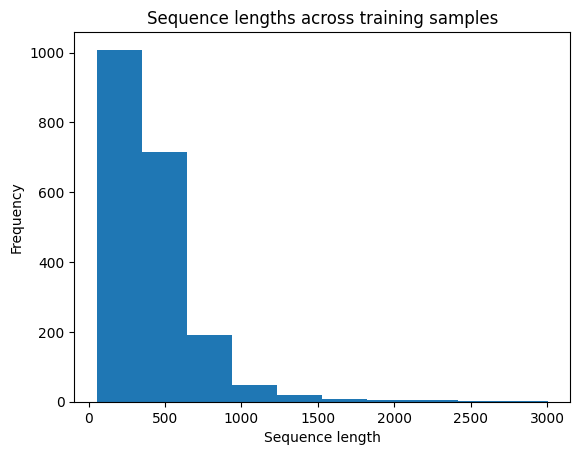

In [12]:
# check sequence lengths
seq_lengths = df_train["Sequence"].apply(len)

print(seq_lengths.describe())

seq_lengths.plot.hist(xlabel="Sequence length", 
                      ylabel="Frequency", 
                      title="Sequence lengths across training samples")

<Axes: title={'center': 'Sequence lengths across test samples'}, xlabel='Sequence length', ylabel='Frequency'>

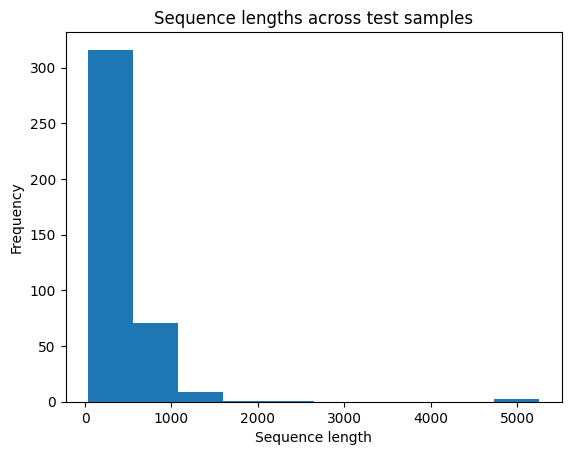

In [11]:
# check sequence lengths
test_seq_lengths = df_test["Sequence"].apply(len)

test_seq_lengths.plot.hist(xlabel="Sequence length", 
                      ylabel="Frequency", 
                      title="Sequence lengths across test samples")

## One-hot encoding

In [18]:
# Define the standard 20 amino acids
# Plus U for selenocysteine which is present in some of our samples
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTUVWY"

def one_hot_encode_protein(seq, max_len=512):
    encoding = np.zeros((max_len, len(AMINO_ACIDS)), dtype=np.int8)
    for i, aa in enumerate(seq[:max_len]):
        if aa != "X":
            encoding[i, AMINO_ACIDS.index(aa)] = 1
    return encoding.flatten()  # Shape: (max_len * 21,)

In [19]:
## Apply encoding to all sequences, full length
X_train = np.stack(df_train["Sequence"].map(lambda s: one_hot_encode_protein(s, max_len=3004)))
X_test = np.stack(df_test["Sequence"].map(lambda s: one_hot_encode_protein(s, max_len=3004)))

# Check shape
print(f"One-hot encoded train set shape: {X_train.shape}")
print(f"One-hot encoded test set shape: {X_test.shape}")

One-hot encoded train set shape: (2000, 63084)
One-hot encoded test set shape: (400, 63084)


## $k$-mer encoding

In [23]:
from collections import Counter
from itertools import product

def kmer_features_protein(seq, k=3):
    # Define k-mer vocabulary from 20 amino acids
    vocab = [''.join(p) for p in product(AMINO_ACIDS, repeat=k)]
    counts = Counter([seq[i:i+k] for i in range(len(seq)-k+1)])
    return np.array([counts.get(kmer, 0) for kmer in vocab], dtype=np.float32)

X_train_kmer = np.stack(df_train["Sequence"].map(lambda s: kmer_features_protein(s, k=3)))
X_test_kmer = np.stack(df_test["Sequence"].map(lambda s: kmer_features_protein(s, k=3)))


print("Shape of 3-mer train feature matrix:", X_train_kmer.shape)
print("Shape of 3-mer test feature matrix:", X_test_kmer.shape)

Shape of k-mer train feature matrix: (2000, 9261)
Shape of k-mer test feature matrix: (400, 9261)


## Count encoding

In [24]:
def count_features_protein(seq):
    vocab = list(AMINO_ACIDS)
    counts = Counter([seq[i:i+1] for i in range(len(seq)-1+1)])
    return np.array([counts.get(kmer, 0) for kmer in vocab], dtype=np.float32)

X_train_count = np.stack(df_train["Sequence"].map(lambda s: count_features_protein(s)))
X_test_count = np.stack(df_test["Sequence"].map(lambda s: count_features_protein(s)))


print("Shape of count-encoded train feature matrix:", X_train_count.shape)
print("Shape of count-encoded test feature matrix:", X_test_count.shape)

Shape of count-encoded train feature matrix: (2000, 21)
Shape of count-encoded test feature matrix: (400, 21)


## Logistic Regression with Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

In [25]:
## Encode EC labels as integer labels

le = LabelEncoder()
y_train = le.fit_transform(df_train["Label"])
y_test = le.transform(df_test["Label"])

# Optional: Show label classes
print("Classes:", le.classes_)

Classes: ['1.1.1.1' '1.1.1.103' '1.1.1.169' '1.1.1.17' '1.1.1.2' '1.1.1.27'
 '1.1.1.35' '1.1.1.37' '1.1.1.42' '1.1.1.47' '1.1.5.3' '1.11.1.24'
 '1.11.1.28' '1.11.1.5' '1.11.1.6' '1.11.1.7' '1.12.98.1' '1.13.11.24'
 '1.14.11.27' '1.14.13.25' '1.14.13.39' '1.14.14.18' '1.14.18.1'
 '1.14.99.60' '1.15.1.1' '1.16.1.9' '1.16.3.1' '1.17.1.4' '1.17.1.9'
 '1.17.4.1' '1.17.99.6' '1.17.99.9' '1.18.1.2' '1.18.1.3' '1.18.6.1'
 '1.2.1.10' '1.2.4.1' '1.2.4.4' '1.2.7.1' '1.2.7.12' '1.2.7.3' '1.20.4.1'
 '1.3.1.104' '1.3.1.9' '1.3.5.1' '1.3.7.7' '1.4.1.1' '1.4.1.13' '1.4.1.2'
 '1.4.3.5' '1.5.1.2' '1.5.1.3' '1.5.1.36' '1.5.1.42' '1.5.3.24' '1.5.98.3'
 '1.6.5.2' '1.6.5.9' '1.7.5.1' '1.8.1.2' '1.8.1.8' '1.8.1.9' '1.8.3.2'
 '1.97.1.12' '2.1.1.17' '2.1.1.228' '2.1.1.320' '2.1.1.33' '2.1.1.355'
 '2.1.1.37' '2.1.1.56' '2.1.1.57' '2.1.1.72' '2.1.1.85' '2.1.1.86'
 '2.1.3.15' '2.2.1.6' '2.3.1.1' '2.3.1.15' '2.3.1.180' '2.3.1.181'
 '2.3.1.184' '2.3.1.199' '2.3.1.20' '2.3.1.225' '2.3.1.28' '2.3.1.30'
 '2.3.1.31' '2

In [26]:
## Train logistic regression (one-hot encoding)
clf = LogisticRegression(
    solver='saga',
    multi_class='multinomial',
    penalty='l2',
    C=0.5,                 # stronger regularization (faster convergence)
    max_iter=300,
    n_jobs=-1,
    verbose=1
)
clf.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [ ]:
## evaluate model
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1-score:", f1_score(y_test, y_pred, average='macro'))

# Optional: Full classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))


In [ ]:
## save encoding data for reuse 

np.savez("convenz_onehot_data.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, classes=le.classes_)


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    clf,
    X_train,
    y_train,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)


In [ ]:
print("5-fold cross-validated F1 scores:", scores)
print("Mean F1:", scores.mean())


## pytorch

In [55]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score


In [58]:
## pytoch for faster training


# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Convert to tensors and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long).to(device)

# Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [59]:
# Define model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

model = LogisticRegression(input_dim=X_train.shape[1], num_classes=len(le.classes_)).to(device)


In [60]:

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(100):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

print("Accuracy:", accuracy_score(y_true, preds))
print("Macro F1:", f1_score(y_true, preds, average='macro'))

Epoch 1, Loss: 186.2881
Epoch 2, Loss: 26.3160
Epoch 3, Loss: 7.5099
Epoch 4, Loss: 3.8692
Epoch 5, Loss: 2.2306
Epoch 6, Loss: 1.4889
Epoch 7, Loss: 1.0753
Epoch 8, Loss: 0.7922
Epoch 9, Loss: 0.6150
Epoch 10, Loss: 0.4854
Epoch 11, Loss: 0.3989
Epoch 12, Loss: 0.3336
Epoch 13, Loss: 0.2819
Epoch 14, Loss: 0.2467
Epoch 15, Loss: 0.2143
Epoch 16, Loss: 0.1892
Epoch 17, Loss: 0.1681
Epoch 18, Loss: 0.1513
Epoch 19, Loss: 0.1500
Epoch 20, Loss: 0.1266
Epoch 21, Loss: 0.1143
Epoch 22, Loss: 0.1048
Epoch 23, Loss: 0.0969
Epoch 24, Loss: 0.0905
Epoch 25, Loss: 0.0829
Epoch 26, Loss: 0.0804
Epoch 27, Loss: 0.0728
Epoch 28, Loss: 0.0700
Epoch 29, Loss: 0.0651
Epoch 30, Loss: 0.0612
Epoch 31, Loss: 0.0567
Epoch 32, Loss: 0.0544
Epoch 33, Loss: 0.0512
Epoch 34, Loss: 0.0498
Epoch 35, Loss: 0.0458
Epoch 36, Loss: 0.0449
Epoch 37, Loss: 0.0440
Epoch 38, Loss: 0.0406
Epoch 39, Loss: 0.0378
Epoch 40, Loss: 0.0362
Epoch 41, Loss: 0.0360
Epoch 42, Loss: 0.0335
Epoch 43, Loss: 0.0324
Epoch 44, Loss: 0

## K-mer Count Feature Variant (e.g., 3-mers)


In [63]:
model = LogisticRegression(input_dim=X_train_kmer.shape[1], num_classes=len(le.classes_)).to(device)
X_train_tensor = torch.tensor(X_train_kmer, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_kmer, dtype=torch.float32).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [64]:


# Training loop
for epoch in range(100):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

print("Accuracy:", accuracy_score(y_true, preds))
print("Macro F1:", f1_score(y_true, preds, average='macro'))


Epoch 1, Loss: 179.8290
Epoch 2, Loss: 31.1953
Epoch 3, Loss: 10.5838
Epoch 4, Loss: 5.6556
Epoch 5, Loss: 3.5489
Epoch 6, Loss: 2.4338
Epoch 7, Loss: 1.7198
Epoch 8, Loss: 1.3128
Epoch 9, Loss: 1.0092
Epoch 10, Loss: 0.8111
Epoch 11, Loss: 0.6477
Epoch 12, Loss: 0.5384
Epoch 13, Loss: 0.4605
Epoch 14, Loss: 0.3873
Epoch 15, Loss: 0.3373
Epoch 16, Loss: 0.3029
Epoch 17, Loss: 0.2632
Epoch 18, Loss: 0.2355
Epoch 19, Loss: 0.2127
Epoch 20, Loss: 0.1911
Epoch 21, Loss: 0.1780
Epoch 22, Loss: 0.1640
Epoch 23, Loss: 0.1483
Epoch 24, Loss: 0.1356
Epoch 25, Loss: 0.1276
Epoch 26, Loss: 0.1190
Epoch 27, Loss: 0.1104
Epoch 28, Loss: 0.1068
Epoch 29, Loss: 0.0974
Epoch 30, Loss: 0.0909
Epoch 31, Loss: 0.0866
Epoch 32, Loss: 0.0825
Epoch 33, Loss: 0.0761
Epoch 34, Loss: 0.0728
Epoch 35, Loss: 0.0698
Epoch 36, Loss: 0.0662
Epoch 37, Loss: 0.0623
Epoch 38, Loss: 0.0598
Epoch 39, Loss: 0.0567
Epoch 40, Loss: 0.0554
Epoch 41, Loss: 0.0522
Epoch 42, Loss: 0.0494
Epoch 43, Loss: 0.0476
Epoch 44, Loss: 

## blast based evaluation

In [65]:
#step 1: write sequences to fasta
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO

# Write training sequences
train_records = [
    SeqRecord(Seq(seq), id=entry, description=label)
    for seq, entry, label in zip(df_train["Sequence"], df_train["Entry"], df_train["Label"])
]
SeqIO.write(train_records, "train_set.fasta", "fasta")

# Write test sequences
test_records = [
    SeqRecord(Seq(seq), id=entry, description=label)
    for seq, entry, label in zip(df_test["Sequence"], df_test["Entry"], df_test["Label"])
]
SeqIO.write(test_records, "test_set.fasta", "fasta")


400

In [37]:
# #run this from terminal and save the blast results.txt 
# #step 2 : create BLAST DB
# !makeblastdb -in train_set.fasta -dbtype prot -out train_db
# # step 3- run blast
# !blastp -query test_set.fasta -db train_db -outfmt "6 qseqid sseqid pident length" -out blast_results.txt

In [ ]:
## parse blast results and evaluate

In [66]:
df_train[["Entry", "Label"]].to_csv("train_metadata.csv", index=False)
df_test[["Entry", "Label"]].to_csv("test_metadata.csv", index=False)


In [67]:

# Load BLAST results
blast_df = pd.read_csv("blast_results.txt", sep="\t", header=None,
                       names=["query", "subject", "pident", "length", "bitscore"])

# Load EC label mapping
df_train = pd.read_csv("train_metadata.csv")  # Contains Entry and Label
df_test = pd.read_csv("test_metadata.csv")

entry_to_label = dict(zip(df_train["Entry"], df_train["Label"]))
true_labels = dict(zip(df_test["Entry"], df_test["Label"]))

# Predict using top BLAST hit
blast_df["pred_label"] = blast_df["subject"].map(entry_to_label)
blast_df["true_label"] = blast_df["query"].map(true_labels)

# Drop NA (if any query had no match)
blast_df = blast_df.dropna(subset=["pred_label", "true_label"])

from sklearn.metrics import accuracy_score, f1_score

y_true = blast_df["true_label"]
y_pred = blast_df["pred_label"]

print("BLAST Accuracy:", accuracy_score(y_true, y_pred))
print("BLAST Macro F1:", f1_score(y_true, y_pred, average='macro'))



BLAST Accuracy: 0.001869741352446245
BLAST Macro F1: 0.0007941176470588235


In [68]:
## check for missing predictions
missed = set(df_test["Entry"]) - set(blast_df["query"])
print(f"{len(missed)} test sequences had no BLAST hits.")


1 test sequences had no BLAST hits.
